In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import col, to_timestamp, udf
from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pymongo import MongoClient 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
import time
import nltk
import numpy as np

In [2]:
spark = SparkSession.builder \
    .appName("Assignment") \
    .getOrCreate()

In [3]:
schema = StructType([
    StructField("serial_no", LongType(), True),
    StructField("ids", LongType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)
])

In [4]:
dataset = "ProjectTweets.csv"
df = spark.read.csv(dataset, schema=schema, header=False)

In [5]:
df.show()

+---------+----------+--------------------+--------+---------------+--------------------+
|serial_no|       ids|                date|    flag|           user|                text|
+---------+----------+--------------------+--------+---------------+--------------------+
|        0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|        1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|        2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|        3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|        4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|        5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|        6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|        7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|        8

In [6]:
df = df.drop("serial_no")

In [7]:
df.printSchema()

root
 |-- ids: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [8]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [9]:
df = df.withColumn("date", to_timestamp(col("date"), "EEE MMM dd HH:mm:ss"))

In [10]:
df.show()

+----------+-------------------+--------+---------------+--------------------+
|       ids|               date|    flag|           user|                text|
+----------+-------------------+--------+---------------+--------------------+
|1467810369|1970-04-06 22:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|1467810672|1970-04-06 22:19:49|NO_QUERY|  scotthamilton|is upset that he ...|
|1467810917|1970-04-06 22:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|
|1467811184|1970-04-06 22:19:57|NO_QUERY|        ElleCTF|my whole body fee...|
|1467811193|1970-04-06 22:19:57|NO_QUERY|         Karoli|@nationwideclass ...|
|1467811372|1970-04-06 22:20:00|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|1467811592|1970-04-06 22:20:03|NO_QUERY|        mybirch|         Need a hug |
|1467811594|1970-04-06 22:20:03|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|1467811795|1970-04-06 22:20:05|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|1467812025|1970-04-06 22:20:09|NO_QUERY|        mim

In [11]:
df = df.drop("ids", "flag", "user")

In [12]:
df.show()

+-------------------+--------------------+
|               date|                text|
+-------------------+--------------------+
|1970-04-06 22:19:45|@switchfoot http:...|
|1970-04-06 22:19:49|is upset that he ...|
|1970-04-06 22:19:53|@Kenichan I dived...|
|1970-04-06 22:19:57|my whole body fee...|
|1970-04-06 22:19:57|@nationwideclass ...|
|1970-04-06 22:20:00|@Kwesidei not the...|
|1970-04-06 22:20:03|         Need a hug |
|1970-04-06 22:20:03|@LOLTrish hey  lo...|
|1970-04-06 22:20:05|@Tatiana_K nope t...|
|1970-04-06 22:20:09|@twittera que me ...|
|1970-04-06 22:20:16|spring break in p...|
|1970-04-06 22:20:17|I just re-pierced...|
|1970-04-06 22:20:19|@caregiving I cou...|
|1970-04-06 22:20:19|@octolinz16 It it...|
|1970-04-06 22:20:20|@smarrison i woul...|
|1970-04-06 22:20:20|@iamjazzyfizzle I...|
|1970-04-06 22:20:22|Hollis' death sce...|
|1970-04-06 22:20:25|about to file taxes |
|1970-04-06 22:20:31|@LettyA ahh ive a...|
|1970-04-06 22:20:34|@FakerPattyPattz ...|
+----------

In [13]:
# Defining functions for storage time comparison
def store_data_in_spark_sql(df):
    start_time_sql = time.time()
    df.createOrReplaceTempView("tweets")
    end_time_sql = time.time()
    return end_time_sql - start_time_sql

In [14]:
try:
    client = MongoClient('localhost', 27017)
    db = client.admin
    server_status = db.command("serverStatus")
    print("MongoDB is running.")
except Exception as e:
    print("MongoDB is not running or cannot be accessed:", e)

MongoDB is running.


In [15]:
def store_data_in_mongodb(df):
    start_time_mongodb = time.time()
    client = MongoClient('localhost', 27017)
    db = client['twitter_db']
    collection = db['twitter_collection']
    pandas_df = df.toPandas()
    data_dict = pandas_df.to_dict(orient='records')
    
    collection.insert_many(data_dict)
    end_time_mongodb = time.time()
    return end_time_mongodb - start_time_mongodb

In [16]:
time_spark_sql = store_data_in_spark_sql(df)

In [17]:
time_mongodb = store_data_in_mongodb(df)

In [18]:
print("Time taken to store data in Spark SQL:", time_spark_sql, "seconds")

Time taken to store data in Spark SQL: 0.04100823402404785 seconds


In [19]:
print("Time taken to store data in MongoDB:", time_mongodb, "seconds")

Time taken to store data in MongoDB: 79.84203290939331 seconds


In [28]:
spark.stop()

In [20]:
# Sentiment Analysis and Time-Series Forecasting

In [21]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
data = pd.read_csv('ProjectTweets.csv', encoding='latin-1')
data.columns = ['serial no','id', 'date', 'flag', 'user', 'text']

In [23]:
data.head(5)

,serial no,id,date,flag,user,text
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [24]:
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [25]:
print(data.head())

   serial no          id                          date      flag  \
0          1  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
1          2  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
2          3  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
3          4  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          5  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY   

            user                                               text  
0  scotthamilton  is upset that he can't update his Facebook by ...  
1       mattycus  @Kenichan I dived many times for the ball. Man...  
2        ElleCTF    my whole body feels itchy and like its on fire   
3         Karoli  @nationwideclass no, it's not behaving at all....  
4       joy_wolf                      @Kwesidei not the whole crew   


In [26]:
data['sentiment'] = data['text'].apply(get_sentiment)

In [27]:
print(data.head())

   serial no          id                          date      flag  \
0          1  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
1          2  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
2          3  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
3          4  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          5  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY   

            user                                               text sentiment  
0  scotthamilton  is upset that he can't update his Facebook by ...   neutral  
1       mattycus  @Kenichan I dived many times for the ball. Man...  positive  
2        ElleCTF    my whole body feels itchy and like its on fire   positive  
3         Karoli  @nationwideclass no, it's not behaving at all....  negative  
4       joy_wolf                      @Kwesidei not the whole crew   positive  


In [28]:
data.head(5)

,serial no,id,date,flag,user,text,sentiment
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,neutral
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,positive
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,positive
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",negative
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,positive


In [29]:
data['date'] = pd.to_datetime(data['date']).dt.date

C:\Users\Aryan\AppData\Local\Temp\ipykernel_12744\2908055719.py:1: FutureWarning: Parsed string "Mon Apr 06 22:19:49 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  data['date'] = pd.to_datetime(data['date']).dt.date


In [30]:
data.head(5)

,serial no,id,date,flag,user,text,sentiment
0,1,1467810672,2009-04-06,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,neutral
1,2,1467810917,2009-04-06,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,positive
2,3,1467811184,2009-04-06,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,positive
3,4,1467811193,2009-04-06,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",negative
4,5,1467811372,2009-04-06,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,positive


In [31]:
daily_sentiment_counts = data.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

In [32]:
daily_sentiment_counts['total_tweets'] = daily_sentiment_counts.sum(axis=1)


In [33]:
daily_sentiment_counts['percentage_positive'] = (daily_sentiment_counts['positive'] / daily_sentiment_counts['total_tweets']) * 100
daily_sentiment_counts['percentage_negative'] = (daily_sentiment_counts['negative'] / daily_sentiment_counts['total_tweets']) * 100
daily_sentiment_counts['percentage_neutral'] = (daily_sentiment_counts['neutral'] / daily_sentiment_counts['total_tweets']) * 100


In [34]:
daily_sentiment_counts.reset_index(inplace=True)

In [35]:
print(daily_sentiment_counts.columns)

Index(['date', 'negative', 'neutral', 'positive', 'total_tweets',
       'percentage_positive', 'percentage_negative', 'percentage_neutral'],
      dtype='object', name='sentiment')


In [36]:
print(daily_sentiment_counts.head())

sentiment        date  negative  neutral  positive  total_tweets  \
0          2009-04-06       684     1151      1524          3359   
1          2009-04-07      3490     6050      7771         17311   
2          2009-04-17       556     1052      1476          3084   
3          2009-04-18      4099     7713      9942         21754   
4          2009-04-19      5020     9797     12652         27469   

sentiment  percentage_positive  percentage_negative  percentage_neutral  
0                    45.370646            20.363203           34.266151  
1                    44.890532            20.160592           34.948876  
2                    47.859922            18.028534           34.111543  
3                    45.701940            18.842512           35.455548  
4                    46.059194            18.275147           35.665659  


In [37]:
daily_sentiment_counts.head(5)

sentiment,date,negative,neutral,positive,total_tweets,percentage_positive,percentage_negative,percentage_neutral
0,2009-04-06,684,1151,1524,3359,45.370646,20.363203,34.266151
1,2009-04-07,3490,6050,7771,17311,44.890532,20.160592,34.948876
2,2009-04-17,556,1052,1476,3084,47.859922,18.028534,34.111543
3,2009-04-18,4099,7713,9942,21754,45.701940,18.842512,35.455548
4,2009-04-19,5020,9797,12652,27469,46.059194,18.275147,35.665659


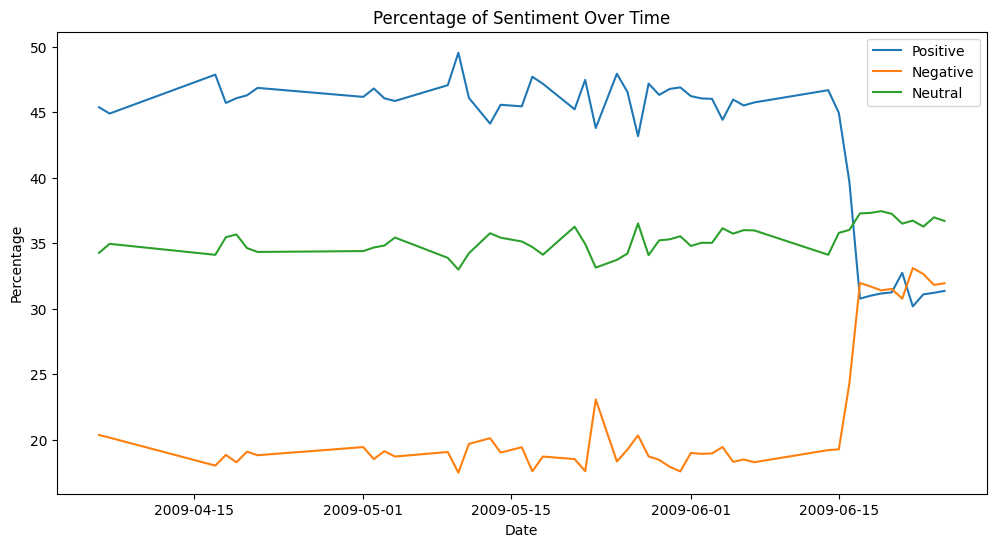

In [38]:
plt.figure(figsize=(12, 6))

plt.plot(daily_sentiment_counts['date'], daily_sentiment_counts['percentage_positive'], label='Positive')
plt.plot(daily_sentiment_counts['date'], daily_sentiment_counts['percentage_negative'], label='Negative')
plt.plot(daily_sentiment_counts['date'], daily_sentiment_counts['percentage_neutral'], label='Neutral')
plt.title('Percentage of Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [39]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [40]:
positive_series = daily_sentiment_counts['percentage_positive']
negative_series = daily_sentiment_counts['percentage_negative']
neutral_series = daily_sentiment_counts['percentage_neutral']


In [41]:
def prepare_data(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    series = series.values.reshape(-1, 1)
    series_scaled = scaler.fit_transform(series)
    return series_scaled, scaler

In [42]:
def create_dataset(series, look_back=1):
    X, y = [], []
    for i in range(len(series)-look_back):
        X.append(series[i:(i+look_back), 0])
        y.append(series[i + look_back, 0])
    return np.array(X), np.array(y)


In [43]:
look_back = 3

In [44]:
positive_series_scaled, positive_scaler = prepare_data(positive_series)
X_positive, y_positive = create_dataset(positive_series_scaled, look_back)
negative_series_scaled, negative_scaler = prepare_data(negative_series)
X_negative, y_negative = create_dataset(negative_series_scaled, look_back)
X_negative = np.reshape(X_negative, (X_negative.shape[0], X_negative.shape[1], 1))

neutral_series_scaled, neutral_scaler = prepare_data(neutral_series)
X_neutral, y_neutral = create_dataset(neutral_series_scaled, look_back)
X_neutral = np.reshape(X_neutral, (X_neutral.shape[0], X_neutral.shape[1], 1))


In [45]:
X_positive = np.reshape(X_positive, (X_positive.shape[0], X_positive.shape[1], 1))


In [46]:
# Building LSTM model

In [47]:
lstm_model_positive = Sequential()
lstm_model_positive.add(LSTM(50, input_shape=(look_back, 1)))
lstm_model_positive.add(Dense(1))
lstm_model_positive.compile(loss='mean_squared_error', optimizer='adam')
lstm_model_positive.fit(X_positive, y_positive, epochs=1, batch_size=1, verbose=2)


C:\Users\Aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 - 1s - 26ms/step - loss: 0.2103


In [48]:
lstm_model_negative = Sequential()
lstm_model_negative.add(LSTM(50, input_shape=(look_back, 1)))
lstm_model_negative.add(Dense(1))
lstm_model_negative.compile(loss='mean_squared_error', optimizer='adam')
lstm_model_negative.fit(X_negative, y_negative, epochs=1, batch_size=1, verbose=2)

45/45 - 1s - 22ms/step - loss: 0.1330


In [49]:
lstm_model_neutral = Sequential()
lstm_model_neutral.add(LSTM(50, input_shape=(look_back, 1)))
lstm_model_neutral.add(Dense(1))
lstm_model_neutral.compile(loss='mean_squared_error', optimizer='adam')
lstm_model_neutral.fit(X_neutral, y_neutral, epochs=1, batch_size=1, verbose=2)


45/45 - 1s - 22ms/step - loss: 0.1818


In [52]:
forecast_positive_lstm = []
input_seq_positive = positive_series_scaled[-look_back:].reshape((1, look_back, 1))
for _ in range(7):
    pred = lstm_model_positive.predict(input_seq_positive)
    forecast_positive_lstm.append(pred[0, 0])
    input_seq_positive = np.append(input_seq_positive[:, 1:, :], pred.reshape((1, 1, 1)), axis=1)
forecast_positive_lstm = positive_scaler.inverse_transform(np.array(forecast_positive_lstm).reshape(-1, 1))

forecast_negative_lstm = []
input_seq_negative = negative_series_scaled[-look_back:].reshape((1, look_back, 1))
for _ in range(7):
    pred = lstm_model_negative.predict(input_seq_negative)
    forecast_negative_lstm.append(pred[0, 0])
    input_seq_negative = np.append(input_seq_negative[:, 1:, :], pred.reshape((1, 1, 1)), axis=1)
forecast_negative_lstm = negative_scaler.inverse_transform(np.array(forecast_negative_lstm).reshape(-1, 1))

forecast_neutral_lstm = []
input_seq_neutral = neutral_series_scaled[-look_back:].reshape((1, look_back, 1))
for _ in range(7):
    pred = lstm_model_neutral.predict(input_seq_neutral)
    forecast_neutral_lstm.append(pred[0, 0])
    input_seq_neutral = np.append(input_seq_neutral[:, 1:, :], pred.reshape((1, 1, 1)), axis=1)
forecast_neutral_lstm = neutral_scaler.inverse_transform(np.array(forecast_neutral_lstm).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [53]:
print("\nForecast of 7 days for positive tweets using LSTM:")
print(forecast_positive_lstm)
print("\nForecast for 7 days negative tweets using LSTM:")
print(forecast_negative_lstm)
print("\nForecast for 7 days neutral tweets using LSTM:")
print(forecast_neutral_lstm)


Forecast of 7 days for positive tweets using LSTM:
[[36.0567  ]
 [36.72052 ]
 [37.77215 ]
 [39.203213]
 [39.778732]
 [40.419247]
 [40.99172 ]]

Forecast for 7 days negative tweets using LSTM:
[[23.39174 ]
 [22.823187]
 [21.980661]
 [20.901836]
 [20.705534]
 [20.503468]
 [20.356321]]

Forecast for 7 days neutral tweets using LSTM:
[[35.6374  ]
 [35.622417]
 [35.40026 ]
 [35.1809  ]
 [35.12194 ]
 [35.041462]
 [34.984665]]


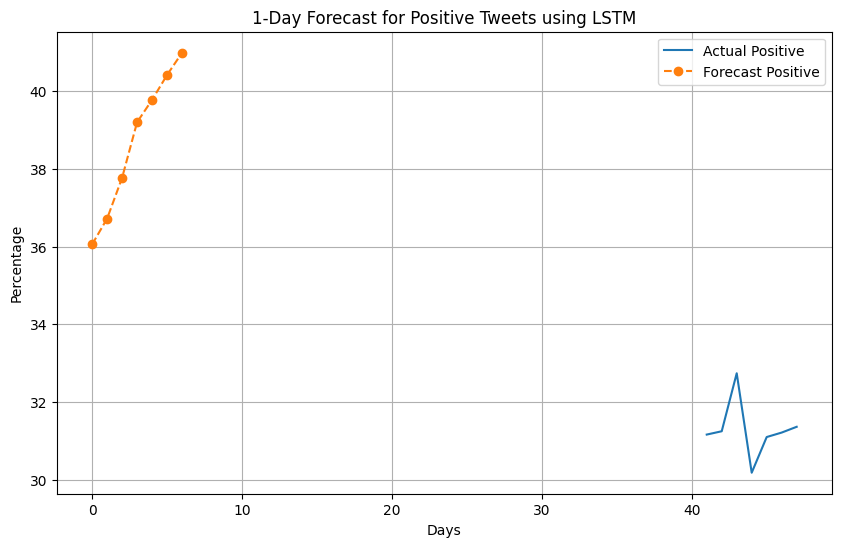

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(daily_sentiment_counts.index[-7:], positive_series.values[-7:], label='Actual Positive')
plt.plot(range(7), forecast_positive_lstm, label='Forecast Positive', linestyle='--', marker='o')
plt.title('1-Day Forecast for Positive Tweets using LSTM')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()

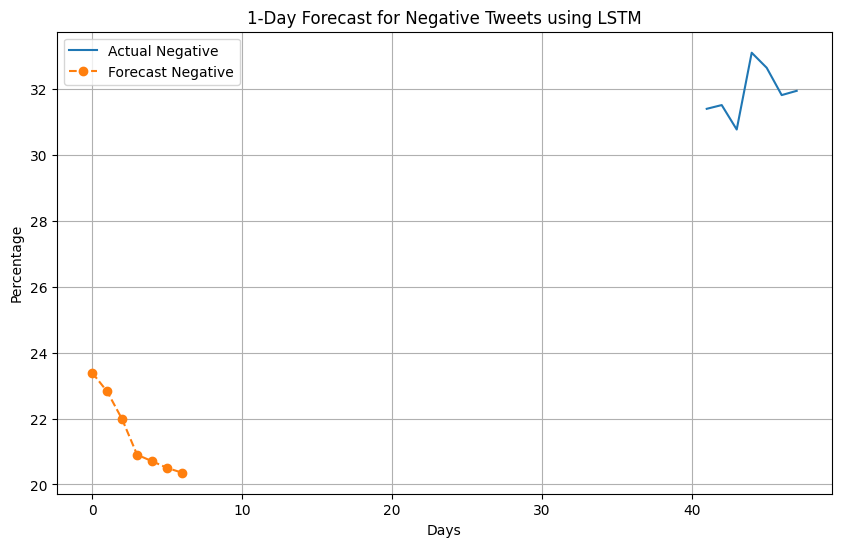

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(daily_sentiment_counts.index[-7:], negative_series.values[-7:], label='Actual Negative')
plt.plot(range(7), forecast_negative_lstm, label='Forecast Negative', linestyle='--', marker='o')
plt.title('1-Day Forecast for Negative Tweets using LSTM')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()

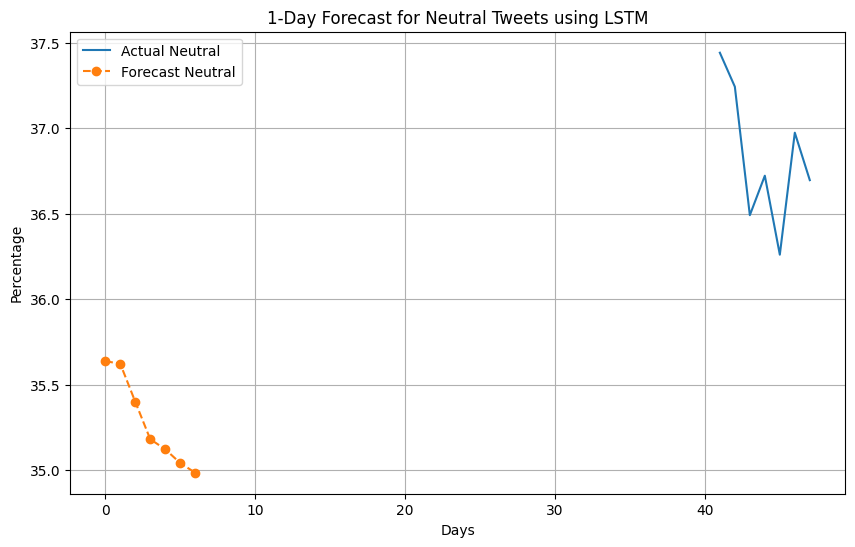

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(daily_sentiment_counts.index[-7:], neutral_series.values[-7:], label='Actual Neutral')
plt.plot(range(7), forecast_neutral_lstm, label='Forecast Neutral', linestyle='--', marker='o')
plt.title('1-Day Forecast for Neutral Tweets using LSTM')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()

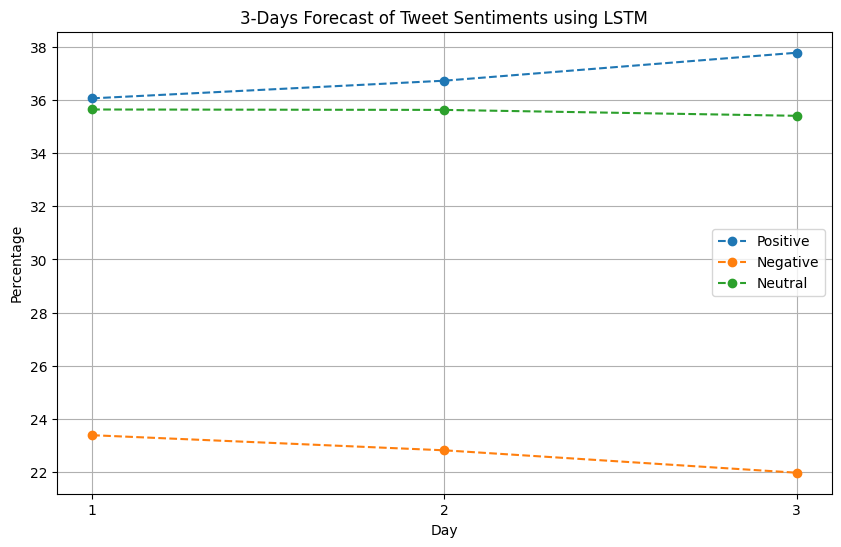

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 4), forecast_positive_lstm[:3], label='Positive',  linestyle='--',marker='o')
plt.plot(range(1, 4), forecast_negative_lstm[:3], label='Negative',  linestyle='--',marker='o')
plt.plot(range(1, 4), forecast_neutral_lstm[:3], label='Neutral',  linestyle='--',marker='o')

plt.title('3-Days Forecast of Tweet Sentiments using LSTM')
plt.xlabel('Day')
plt.ylabel('Percentage')
plt.xticks(range(1, 4))
plt.legend()
plt.grid(True)
plt.show()

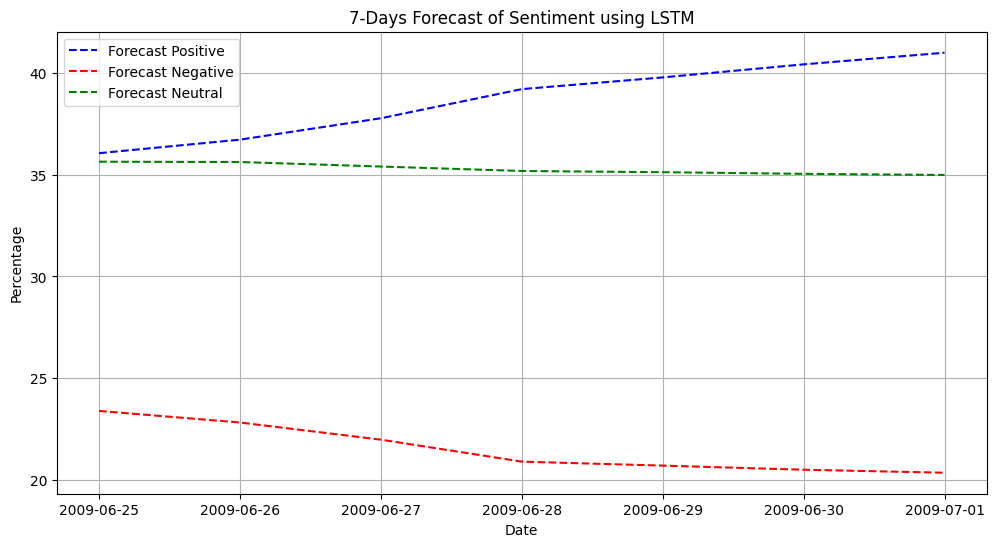

In [58]:

forecast_dates = pd.date_range(start=daily_sentiment_counts['date'].iloc[-1], periods=7)
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecast_positive_lstm, label='Forecast Positive', linestyle='--', color='blue')
plt.plot(forecast_dates, forecast_negative_lstm, label='Forecast Negative', linestyle='--', color='red')
plt.plot(forecast_dates, forecast_neutral_lstm, label='Forecast Neutral', linestyle='--', color='green')

plt.title('7-Days Forecast of Sentiment using LSTM')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
#Using ARIMA

In [60]:
positive_series = daily_sentiment_counts['percentage_positive']
model_positive = ARIMA(positive_series, order=(5,1,0))
fit_positive = model_positive.fit()
forecast_positive = fit_positive.forecast(steps=1)
forecast_positive3 = fit_positive.forecast(steps=3)
forecast_positive7 = fit_positive.forecast(steps=7)

In [61]:
negative_series = daily_sentiment_counts['percentage_negative']
model_negative = ARIMA(negative_series, order=(5,1,0))
fit_negative = model_negative.fit()
forecast_negative = fit_negative.forecast(steps=1)
forecast_negative3 = fit_negative.forecast(steps=3)
forecast_negative7= fit_negative.forecast(steps=7)

In [62]:
neutral_series = daily_sentiment_counts['percentage_neutral']
model_neutral = ARIMA(neutral_series, order=(5,1,0))
fit_neutral = model_neutral.fit()
forecast_neutral = fit_neutral.forecast(steps=1)
forecast_neutral3 = fit_neutral.forecast(steps=3)
forecast_neutral7 = fit_neutral.forecast(steps=7)

In [63]:
print('1 Day Forecast using ARIMA:')
print("\nForecast for positive tweets in %:")
print(list(forecast_positive))
print("\nForecast for negative tweets in %:")
print(list(forecast_negative))
print("\nForecast for neutral tweets in %:")
print(list(forecast_neutral))

1 Day Forecast using ARIMA:

Forecast for positive tweets in %:
[32.34492232108406]

Forecast for negative tweets in %:
[31.34892129072039]

Forecast for neutral tweets in %:
[36.68838189562172]


In [64]:
print('3 Days Forecast using ARIMA:')
print("\nForecast for positive tweets in %:")
print(list(forecast_positive3))
print("\nForecast for negative tweets in %:")
print(list(forecast_negative3))
print("\nForecast for neutral tweets in %:")
print(list(forecast_neutral3))

3 Days Forecast using ARIMA:

Forecast for positive tweets in %:
[32.34492232108406, 31.566717267059147, 31.73636350136458]

Forecast for negative tweets in %:
[31.34892129072039, 31.664697352067034, 31.742594521800672]

Forecast for neutral tweets in %:
[36.68838189562172, 36.59434946199708, 36.5938331705757]


In [65]:
print('7 Days Forecast using ARIMA:')
print("\nForecast for positive tweets in %:")
print(list(forecast_positive7))
print("\nForecast for negative tweets in %:")
print(list(forecast_negative7))
print("\nForecast for neutral tweets in %:")
print(list(forecast_neutral7))

7 Days Forecast using ARIMA:

Forecast for positive tweets in %:
[32.34492232108406, 31.566717267059147, 31.73636350136458, 31.777708031296363, 31.542110284220637, 31.952701331063388, 31.74583154107964]

Forecast for negative tweets in %:
[31.34892129072039, 31.664697352067034, 31.742594521800672, 31.558438519892352, 31.7230559434153, 31.58732397932787, 31.60335290994632]

Forecast for neutral tweets in %:
[36.68838189562172, 36.59434946199708, 36.5938331705757, 36.7182035289791, 36.6941476466044, 36.67725679313005, 36.63672753065479]


In [66]:
#Dyanamic Dashboard

In [67]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA


In [68]:
app = dash.Dash(__name__)
def forecast_sentiment(series, steps):
    model = ARIMA(series, order=(5, 1, 0))
    fit = model.fit()
    forecast = fit.forecast(steps=steps)
    return forecast

In [69]:
# Layout of the dashboard
app.layout = html.Div([
    html.H1("Sentiment Analysis and Forecasting Dashboard"),
    
    html.Div([
        dcc.Dropdown(
            id='forecast-interval',
            options=[
                {'label': '1 Day', 'value': 1},
                {'label': '3 Days', 'value': 3},
                {'label': '7 Days', 'value': 7}
            ],
            value=1,
            clearable=False
        ),
    ]),

    dcc.Graph(id='positive-forecast-graph'),
    dcc.Graph(id='negative-forecast-graph'),
    dcc.Graph(id='neutral-forecast-graph')
])

In [70]:
@app.callback(
    [Output('positive-forecast-graph', 'figure'),
     Output('negative-forecast-graph', 'figure'),
     Output('neutral-forecast-graph', 'figure')],
    [Input('forecast-interval', 'value')]
)
def update_graph(forecast_interval):
    # Forecasting for positive sentiment
    positive_series = daily_sentiment_counts['percentage_positive']
    forecast_positive = forecast_sentiment(positive_series, forecast_interval)

    # Forecasting for negative sentiment
    negative_series = daily_sentiment_counts['percentage_negative']
    forecast_negative = forecast_sentiment(negative_series, forecast_interval)

    # Forecasting for neutral sentiment
    neutral_series = daily_sentiment_counts['percentage_neutral']
    forecast_neutral = forecast_sentiment(neutral_series, forecast_interval)

    trace_positive = go.Scatter(
        x=list(range(1, forecast_interval + 1)), 
        y=forecast_positive, 
        mode='lines+markers', 
        name='Positive Forecast'
    )
    layout_positive = go.Layout(
        title='Positive Sentiment Forecast', 
        xaxis=dict(title='Days Ahead'), 
        yaxis=dict(title='Percentage')
    )
    fig_positive = go.Figure(data=[trace_positive], layout=layout_positive)

    trace_negative = go.Scatter(
        x=list(range(1, forecast_interval + 1)), 
        y=forecast_negative, 
        mode='lines+markers', 
        name='Negative Forecast'
    )
    layout_negative = go.Layout(
        title='Negative Sentiment Forecast', 
        xaxis=dict(title='Days Ahead'), 
        yaxis=dict(title='Percentage')
    )
    fig_negative = go.Figure(data=[trace_negative], layout=layout_negative)

    trace_neutral = go.Scatter(
        x=list(range(1, forecast_interval + 1)), 
        y=forecast_neutral, 
        mode='lines+markers', 
        name='Neutral Forecast'
    )
    layout_neutral = go.Layout(
        title='Neutral Sentiment Forecast', 
        xaxis=dict(title='Days Ahead'), 
        yaxis=dict(title='Percentage')
    )
    fig_neutral = go.Figure(data=[trace_neutral], layout=layout_neutral)

    return fig_positive, fig_negative, fig_neutral

In [71]:
# Run the dashboard
if __name__ == '__main__':
    app.run_server(debug=True)

In [96]:
from IPython.display import display, Image

In [103]:
## Images from Dyanamic Dashboard
img=Image(filename='newplot.png')
img2=Image(filename='newplot (1).png')
img3=Image(filename='newplot (2).png')

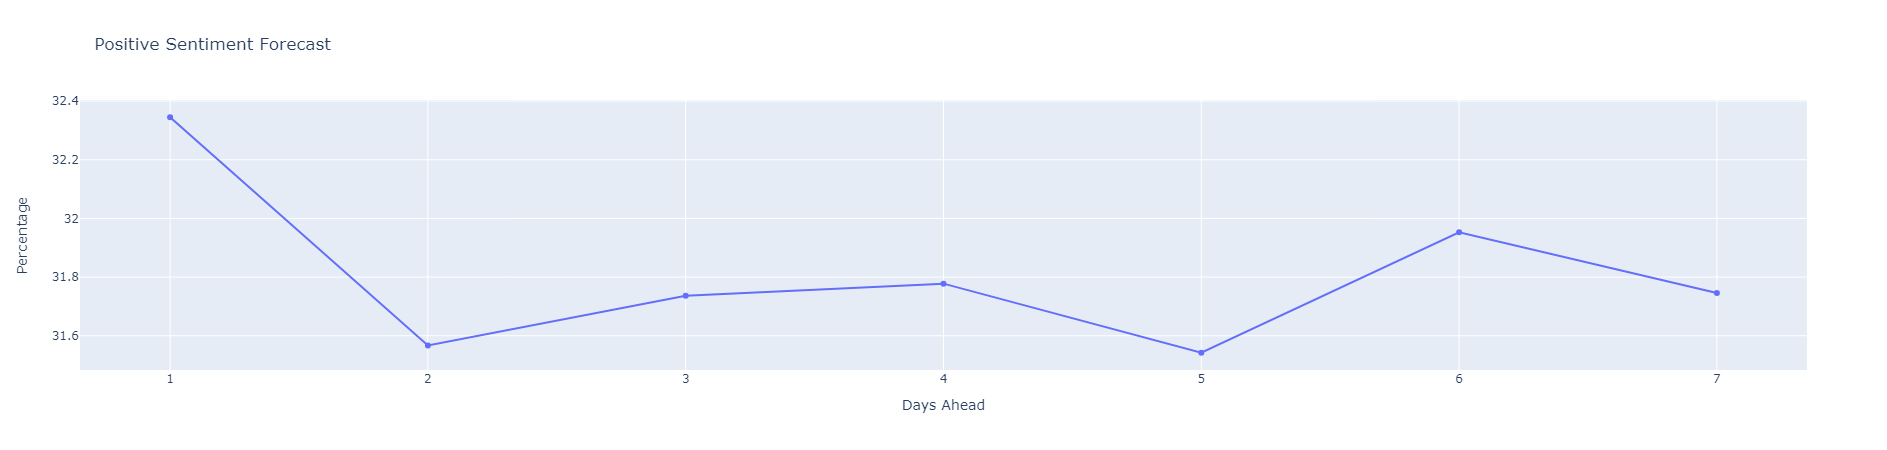

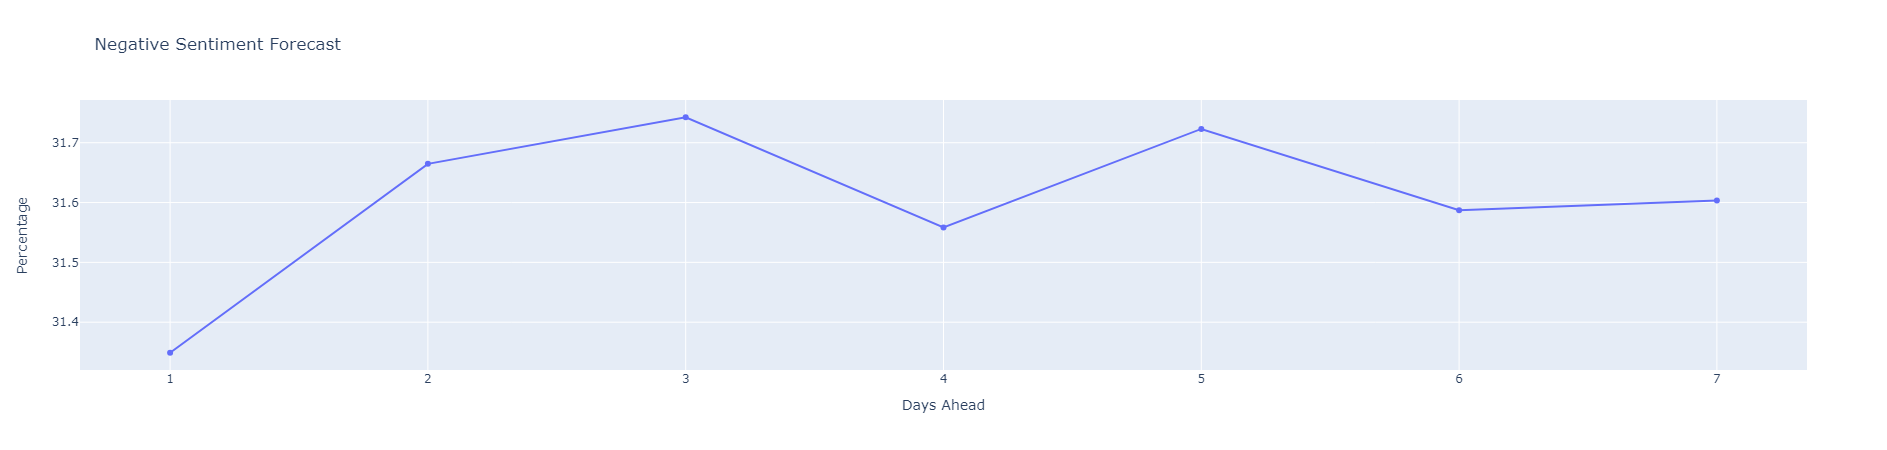

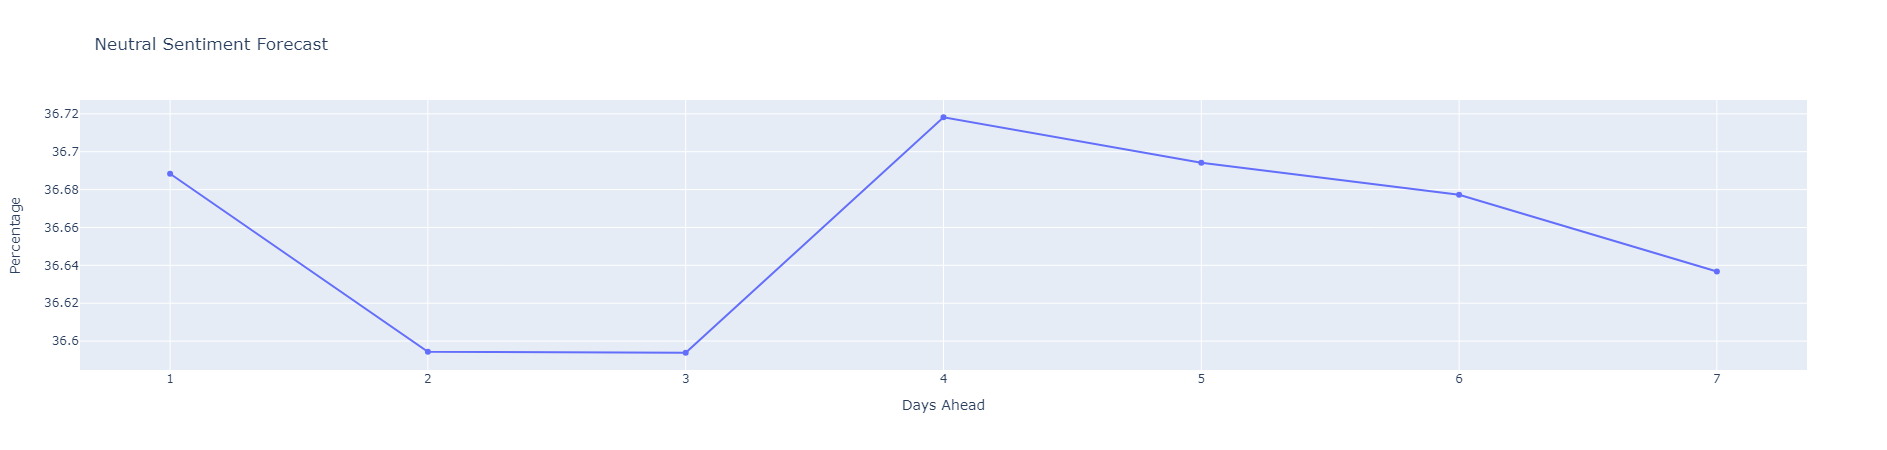

In [104]:
display(img)
display(img2)
display(img3)